In [7]:
#Utility Libs
import pandas as pd
import numpy as np
from IPython.display import Markdown as md
from scipy import stats


#Viz Libs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

#Encoding
from sklearn.preprocessing import LabelEncoder

# Dataset

Let's load the dataset and perform some basic operations then,

1. Check the number of missing values in different columns
2. Fill those missing values with mean,median or mode and check the resulting distribution for any spread change
3. If there is a spread change, use MICE method for imputing instead of mean.

In [141]:
train = pd.read_csv("/home/lustbeast/Datasets/Train_Cleaned/train.csv")
test = pd.read_csv("/home/lustbeast/Datasets/Train_Cleaned/test.csv")

print(f"Train: {train.shape}  \nTest: {test.shape}")

print(f"Train Features: {train.columns} \nTest Features: {test.columns}")

Train: (33126, 8)  
Test: (10982, 5)
Train Features: Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target'],
      dtype='object') 
Test Features: Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge'],
      dtype='object')


<AxesSubplot:ylabel='Density'>

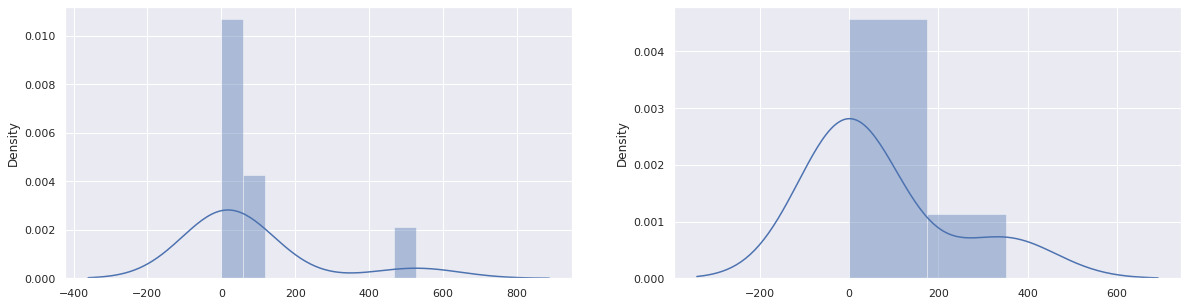

In [54]:
#missing values
train_miss = train.isna().sum()
test_miss = test.isna().sum()
fig,ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(train_miss,ax=ax[0])
sns.distplot(test_miss,ax=ax[1])

Distribution of NaN values in both train and test

<AxesSubplot:ylabel='Density'>

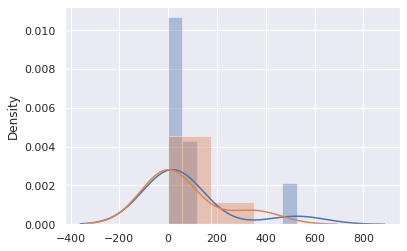

In [55]:
sns.distplot(train_miss)
sns.distplot(test_miss)

In [56]:
test_miss

image_name                         0
patient_id                         0
sex                                0
age_approx                         0
anatom_site_general_challenge    351
dtype: int64

## Imputing

| Train Miss Columns| Quantity |                 
| ----------------- | -------- |                 
| Sex |             | 65 |                       
| Age Approx |      | 68 |    
| Anatom Site General Challenge | |527|

These are the null values present in the train data
Let's summarize, 

1. The sex feature is a categorical variable -> needs to be imputed with mode
2. The age feature is integer variable -> can be imputed by mean or median
3. Anatom site is again a categorical -> mode 


The age and sex features has null values only among the benign class. But, If you check anatom feature, it has 518 null values among benign and 9 null values among malignant. So, have to impute those separately.

In [79]:
sex_null = train[train.sex.isnull()]
age_null = train[train.age_approx.isnull()]
anatom_null = train[train.anatom_site_general_challenge.isnull()]
print(sex_null.shape,age_null.shape,anatom_null.shape)

(65, 8) (68, 8) (527, 8)


In [58]:
#Encoding
tr_v = train.copy()
ts_v = test.copy()
for i in (['sex','anatom_site_general_challenge']):
    lb = LabelEncoder()
    tr_v[i] = tr_v[i].astype(str)
    ts_v[i] = ts_v[i].astype(str)
    tr_v[i] = lb.fit_transform(tr_v[i])
    ts_v[i] = lb.fit_transform(ts_v[i])

Text(0.5, 1.0, 'Test Anatom Site')

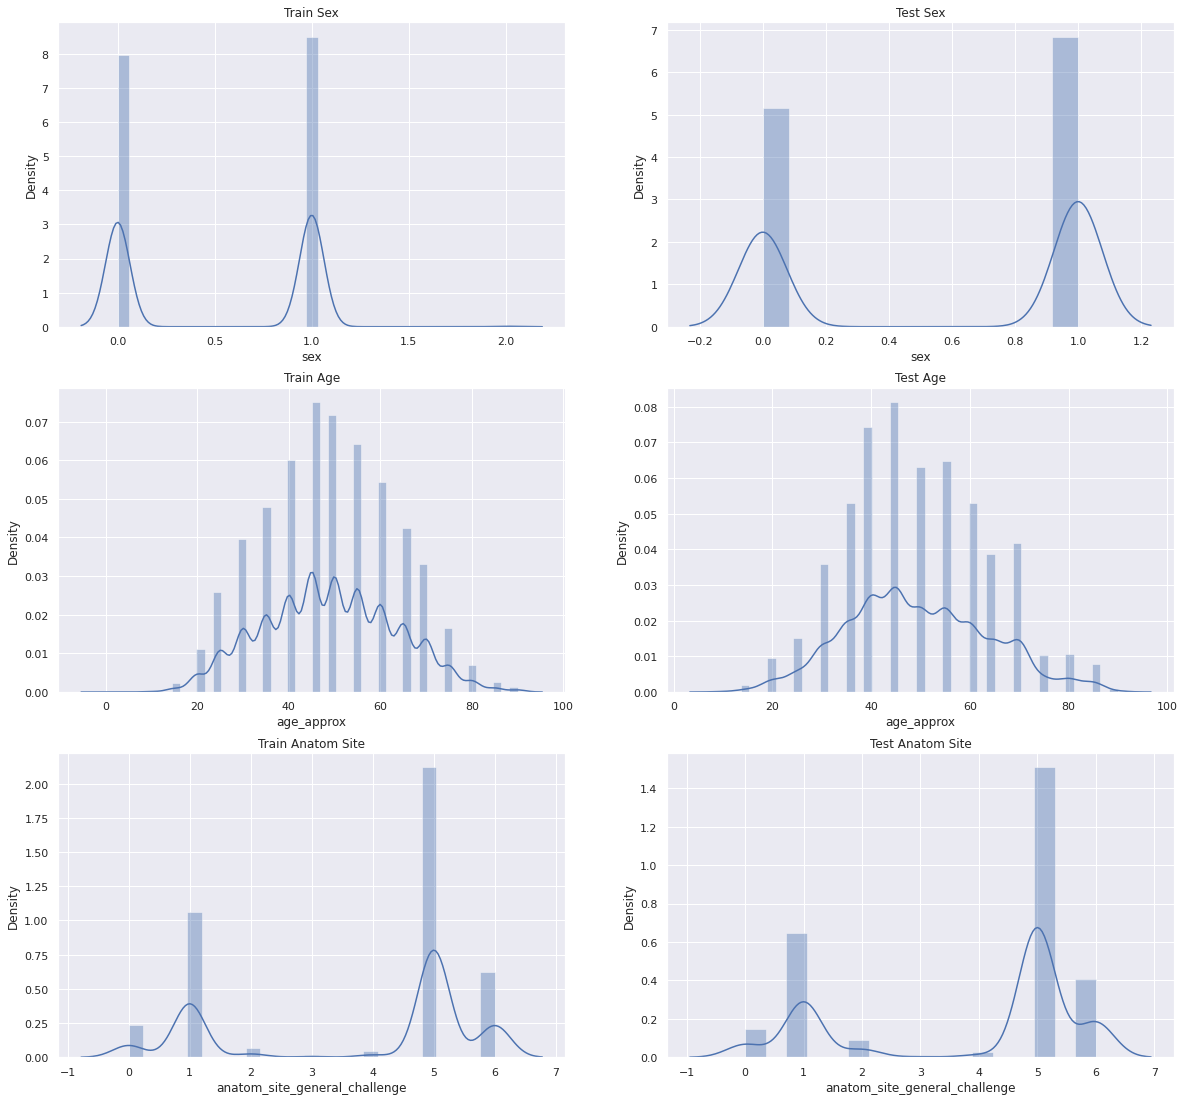

In [59]:
fig,ax = plt.subplots(3,2,figsize=(20,5))
plt.subplots_adjust(top=3)
sns.distplot(tr_v.sex,ax=ax[0][0])
sns.distplot(ts_v.sex,ax=ax[0][1])
sns.distplot(tr_v.age_approx,ax=ax[1][0])
sns.distplot(ts_v.age_approx,ax=ax[1][1])
sns.distplot(tr_v.anatom_site_general_challenge,ax=ax[2][0])
sns.distplot(ts_v.anatom_site_general_challenge,ax=ax[2][1])



ax[0][0].set_title("Train Sex")
ax[0][1].set_title("Test Sex")
ax[1][0].set_title("Train Age")
ax[1][1].set_title("Test Age")
ax[2][0].set_title("Train Anatom Site")
ax[2][1].set_title("Test Anatom Site")

In [60]:
train.anatom_site_general_challenge.value_counts()

torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64

In [61]:
mode = stats.mode(tr_v.sex)
print(mode)

ModeResult(mode=array([1]), count=array([17080]))


In [142]:
train.isna().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

In [143]:
#Age_Approx Imputing
age_indices = np.asarray(age_null.index)
med = np.median(train[train.age_approx.notnull()].age_approx)
print(med)
age_null['age_approx'] = med
train.loc[age_indices,'age_approx'] = age_null['age_approx']

50.0


In [144]:
#Sex imputing
sex_indices = np.asarray(sex_null.index)
mode = stats.mode(train[train.sex.notnull()].sex).mode[0]
print(mode)
sex_null['sex'] = mode
train.loc[sex_indices,'sex'] = sex_null.sex

male


In [145]:
#Anatom Site Imputing
anatom_benign = anatom_null[anatom_null.target==0]
anatom_mal = anatom_null[anatom_null.target==1]
tr_nt_null = train[train.anatom_site_general_challenge.notnull()]
tr_b = tr_nt_null[tr_nt_null.target==0]
tr_m = tr_nt_null[tr_nt_null.target==1]
b_mode = stats.mode(tr_b.anatom_site_general_challenge).mode[0]
m_mode = stats.mode(tr_m.anatom_site_general_challenge).mode[0]
print(b_mode,m_mode)

anatom_benign.anatom_site_general_challenge = b_mode
anatom_mal.anatom_site_general_challenge = m_mode

train.loc[np.asarray(anatom_benign.index),'anatom_site_general_challenge'] = anatom_benign.anatom_site_general_challenge
train.loc[np.asarray(anatom_mal.index),'anatom_site_general_challenge'] = anatom_mal.anatom_site_general_challenge

torso torso


In [146]:
train.isna().sum()

image_name                       0
patient_id                       0
sex                              0
age_approx                       0
anatom_site_general_challenge    0
diagnosis                        0
benign_malignant                 0
target                           0
dtype: int64

In [147]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [148]:
 sex_enc = np.load("sex_encodings.npy",allow_pickle=True)
 an_enc = np.load("anatom_site_general_challenge_encodings.npy",allow_pickle=True)

In [156]:
sex_enc

array(['female', 'male'], dtype=object)

In [154]:
where_sex = lambda x:np.where(sex_enc==x)
where_an = lambda x:np.where(an_enc==x)

In [158]:
train['sex'] = [where_sex(i)[0][0] for i in train.sex.values]
train['anatom_site_general_challenge'] = [where_an(j)[0][0] for j in train.anatom_site_general_challenge.values]

In [159]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,1,45.0,0,unknown,benign,0
1,ISIC_0015719,IP_3075186,0,45.0,5,unknown,benign,0
2,ISIC_0052212,IP_2842074,0,50.0,1,nevus,benign,0
3,ISIC_0068279,IP_6890425,0,45.0,0,unknown,benign,0
4,ISIC_0074268,IP_8723313,0,55.0,5,unknown,benign,0


In [164]:
train.to_csv("CleanedTrain.csv",index=False)

## Uncleaned Vs Cleaned

let's compare our cleaned dataset with the initial dataset and check the dist changes

1. Let's plot the difference in the imputed columns

In [165]:
tr_un = pd.read_csv("Train_Cleaned/train.csv")
tr_cl = pd.read_csv("CleanedTrain.csv")

<AxesSubplot:xlabel='sex', ylabel='Density'>

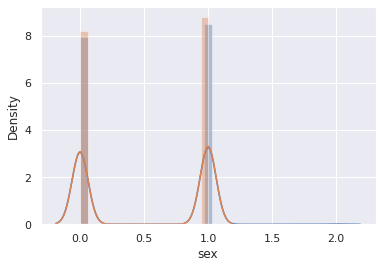

In [167]:
#Sex Plot
sns.distplot(tr_v.sex)
sns.distplot(tr_cl.sex)

There are no changes in the spread.

<AxesSubplot:xlabel='age_approx', ylabel='Density'>

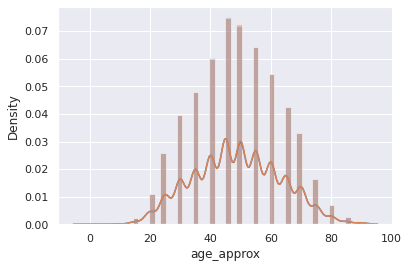

In [168]:
#Age Plot
sns.distplot(tr_v.age_approx)
sns.distplot(tr_cl.age_approx)

<AxesSubplot:xlabel='anatom_site_general_challenge', ylabel='Density'>

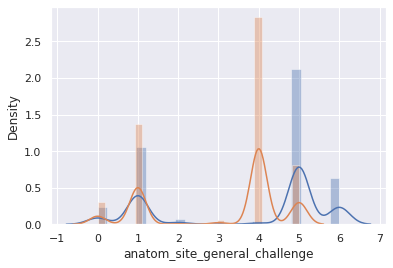

In [170]:
#Anatom Plot
sns.distplot(tr_v.anatom_site_general_challenge)
sns.distplot(tr_cl.anatom_site_general_challenge)

1. There are lot of changes in spread with anatom site imputing
2. The tails are thick after imputing

## Duplicates Removal

In [202]:
dup_list = pd.read_csv("/home/lustbeast/Datasets/2020_Challenge_duplicates.csv")
dup_list = dup_list[dup_list.partition=='train']
len(dup_list)
dups = dup_list.ISIC_id.values
dup_index = [tr_cl[tr_cl.image_name==m].index[0] for m in dups]

In [206]:
dup_list_test = pd.read_csv("/home/lustbeast/Datasets/2020_Challenge_duplicates.csv")
dup_list_test = dup_list_test[dup_list_test.partition=='test']
dup_test_index = [test[test.image_name==n].index[0] for n in dup_list_test.ISIC_id.values]

In [203]:
tr_cl = tr_cl.drop(tr_cl.index[dup_index],axis=0)

In [204]:
tr_cl = tr_cl.reset_index(drop=True)

In [207]:
tr_cl.to_csv("CleanedTrain.csv",index=False)

In [214]:
test = test.drop(test.index[dup_test_index]).reset_index(drop=True)

In [215]:
test.to_csv("CleanedTest.csv",index=False)